# Лабораторная 1. Многослойный персептрон

Для примера построим персептрон для аппроксимации синусоиды

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from dllib.model import MLP
from dllib.utils import device, softmax

plt.rcParams["figure.figsize"] = (20,6)
rng = np.random.default_rng(51)

В нашей нейронной сети будет 3 скрытых слоя, 1 вход, 1 выход. Ограничим обучение 150 эпохами. Архитектура не самая оптимальная, как и обучение с использованием Adam. Можете подобрать более компактную архитектуру. Так как у нас есть случайное начальное заполнение весов, то от запуска к запуску результат может отличаться. При решении задач регрессии полезно не только оценивать решение по метрикам, но и построить график аппроксимации, чтобы увидеть на каких точках алгоритм ошибается.

# Задача для лабораторной 1

По условиям лабораторной 2 надо классифицировать датасет с грибами, который состоит из картегориальных признаков. Поэтому, для начала, посмотрим на сам датасет. Вполне может статься, что нам нужны не все признаки.

Теперь посмотрим на работу с категориальными признаками. Для этого загрузим датасет UCI Machine Learning Repository: Mushroom Data Set(https://archive.ics.uci.edu/ml/datasets/Mushroom). Здесь стоит задача бинарной классификации грибов Агариковые (к ним принадлежит Шампиньон) и Лепиота на два класса: съедобные (edible) и ядовитые (poisonous). Датасет состоит из 8416 строк для двух классов (съедобные - 53,3% и ядовитые - 46,7%). В наличии 22 категориальных признака:
1. форма шляпки (cap-shape): bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
2. поверхность шляпки (cap-surface): fibrous=f,grooves=g,scaly=y,smooth=s
3. цвет шляпки (cap-color): brown=n,buff=b,cinnamon=c,gray=g,green=r, pink=p,purple=u,red=e,white=w,yellow=y
4. повреждения (bruises?): bruises=t,no=f
5. запах (odor): almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
6. соединение пластинки (gill-attachment): attached=a,descending=d,free=f,notched=n
7. пространство между пластинками (gill-spacing): close=c,crowded=w,distant=d
8. размер пластинки (gill-size): broad=b,narrow=n
9. цвет пластинок (gill-color): black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e, white=w,yellow=y
10. форма ножки (stalk-shape): enlarging=e,tapering=t
11. корень ножки (stalk-root): bulbous=b,club=c,cup=u,equal=e, rhizomorphs=z,rooted=r,missing=?
12. поверхность ножки над кольцом (stalk-surface-above-ring): fibrous=f,scaly=y,silky=k,smooth=s
13. поверхность ножки под кольцом (stalk-surface-below-ring): fibrous=f,scaly=y,silky=k,smooth=s
14. цвет ножки над кольцом (stalk-color-above-ring): brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
15. цвет ножки под кольцом (stalk-color-below-ring): brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
16. тип покрывала (veil-type): partial=p,universal=u
17. цвет покрывала (veil-color): brown=n,orange=o,white=w,yellow=y
18. количество колец (ring-number): none=n,one=o,two=t
19. тип кольца (ring-type): cobwebby=c,evanescent=e,flaring=f,large=l, none=n,pendant=p,sheathing=s,zone=z
20. цвет спорового порошка (spore-print-color): black=k,brown=n,buff=b,chocolate=h,green=r, orange=o,purple=u,white=w,yellow=y
21. популяция (population): abundant=a,clustered=c,numerous=n, scattered=s,several=v,solitary=y
22. среда обитания (habitat): grasses=g,leaves=l,meadows=m,paths=p, urban=u,waste=w,woods=d

In [3]:
dfm=pd.read_csv('Mushroom_dataset', delimiter =",", names=['class-label', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat'])
dfm

,class-label,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
1,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
2,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
3,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
4,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,BROWN,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8411,EDIBLE,KNOBBED,SMOOTH,BROWN,NO,NONE,ATTACHED,CLOSE,BROAD,BROWN,...,SMOOTH,ORANGE,ORANGE,PARTIAL,BROWN,ONE,PENDANT,BROWN,CLUSTERED,LEAVES
8412,EDIBLE,KNOBBED,SMOOTH,BROWN,NO,NONE,ATTACHED,CLOSE,BROAD,BROWN,...,SMOOTH,ORANGE,ORANGE,PARTIAL,BROWN,ONE,PENDANT,ORANGE,SEVERAL,LEAVES
8413,EDIBLE,KNOBBED,SMOOTH,BROWN,NO,NONE,ATTACHED,CLOSE,BROAD,BROWN,...,SMOOTH,ORANGE,ORANGE,PARTIAL,BROWN,ONE,PENDANT,ORANGE,CLUSTERED,LEAVES
8414,EDIBLE,KNOBBED,SMOOTH,BROWN,NO,NONE,ATTACHED,CLOSE,BROAD,BROWN,...,SMOOTH,ORANGE,ORANGE,PARTIAL,BROWN,ONE,PENDANT,BUFF,SEVERAL,LEAVES


# Описательная статистика

Посмотрим на соотношение классов в наборе данных, чтобы оценить сбалансированность выборки

In [4]:
dfm['class-label'].value_counts()

class-label
EDIBLE       4488
POISONOUS    3928
Name: count, dtype: int64

На сей раз в описательной статистике есть почти все что надо: количество (count), мощность (unique), мода (top) и частота моды (freq). Не хватает только процента пропущенных значений.

In [5]:
dfm.describe()

,class-label,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,...,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,EDIBLE,CONVEX,SCALY,BROWN,NO,NONE,FREE,CLOSE,BROAD,BUFF,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,WHITE,SEVERAL,WOODS
freq,4488,3796,3268,2320,5040,3808,8200,6824,5880,1728,...,5076,4744,4640,8416,8216,7768,3968,2424,4064,3160


# Распределения

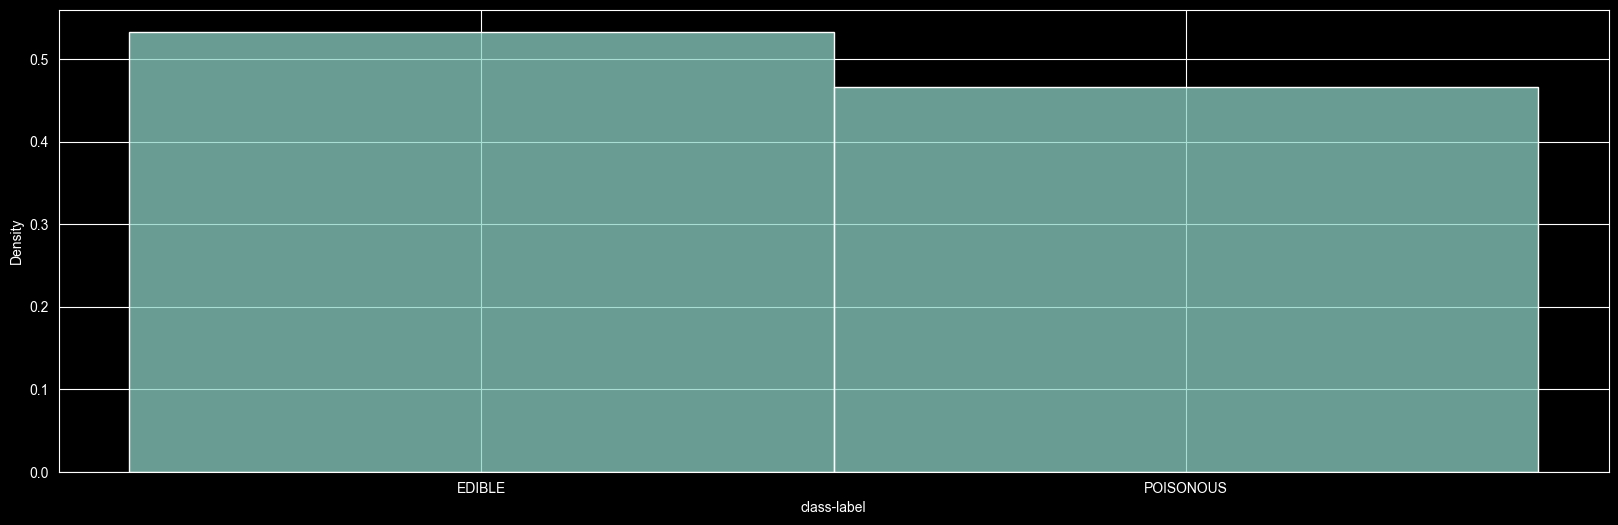

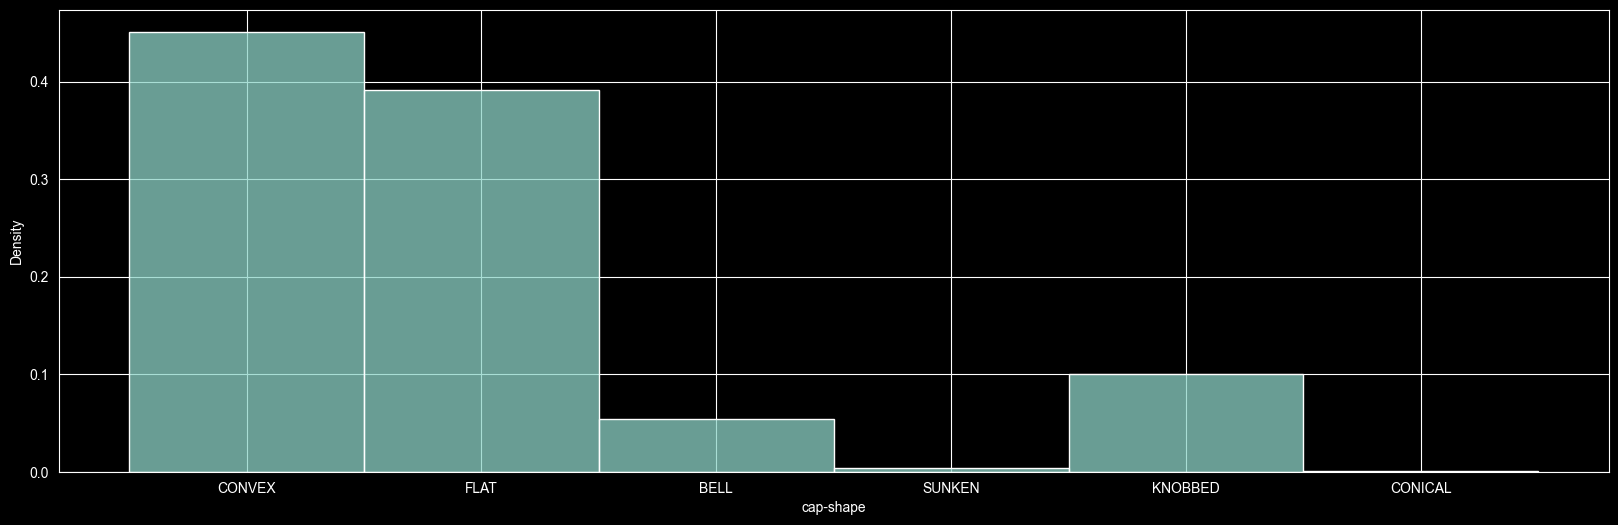

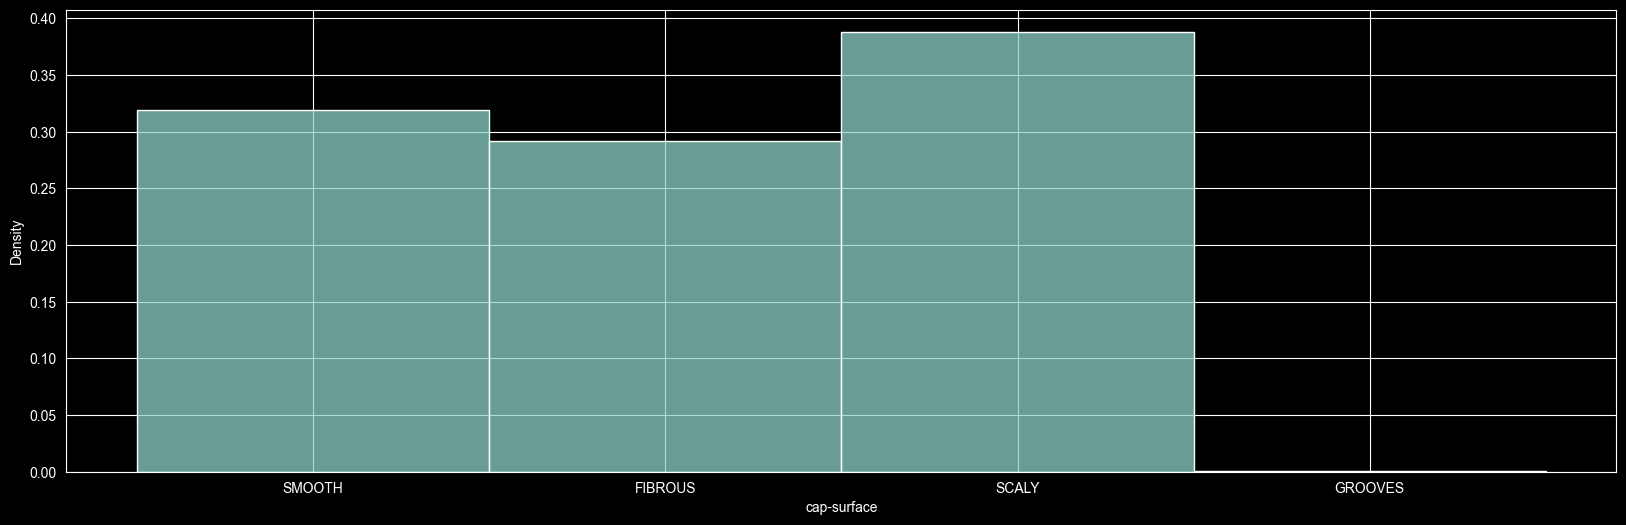

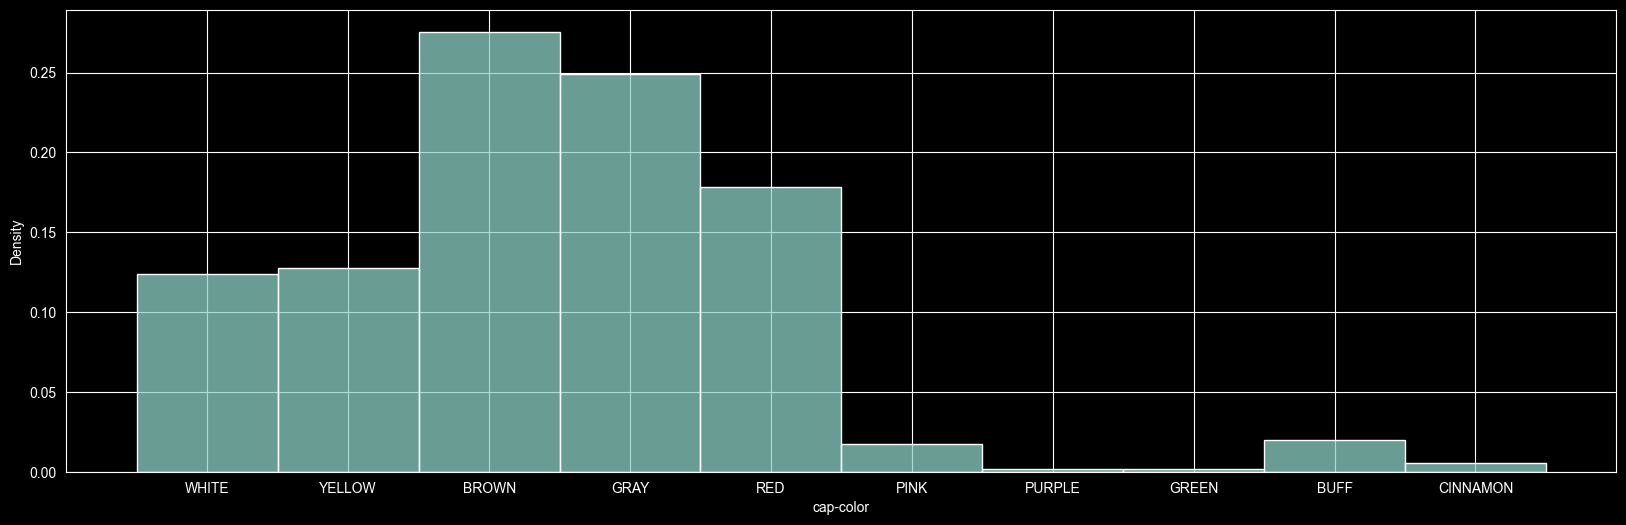

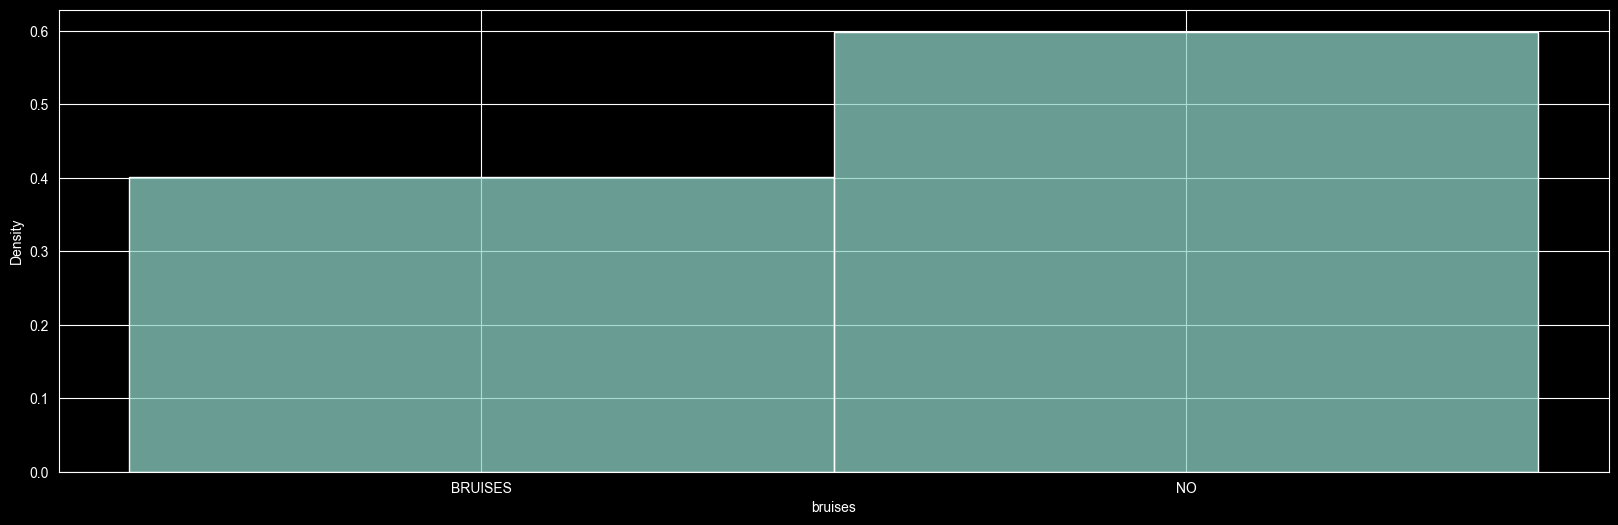

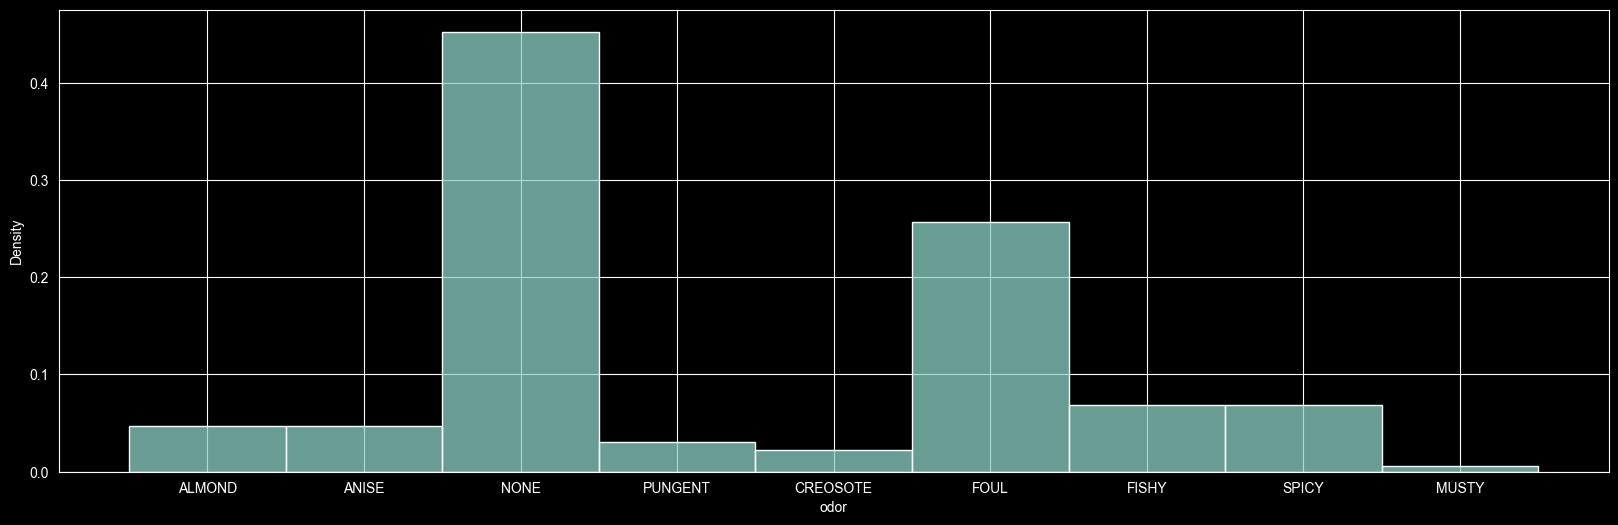

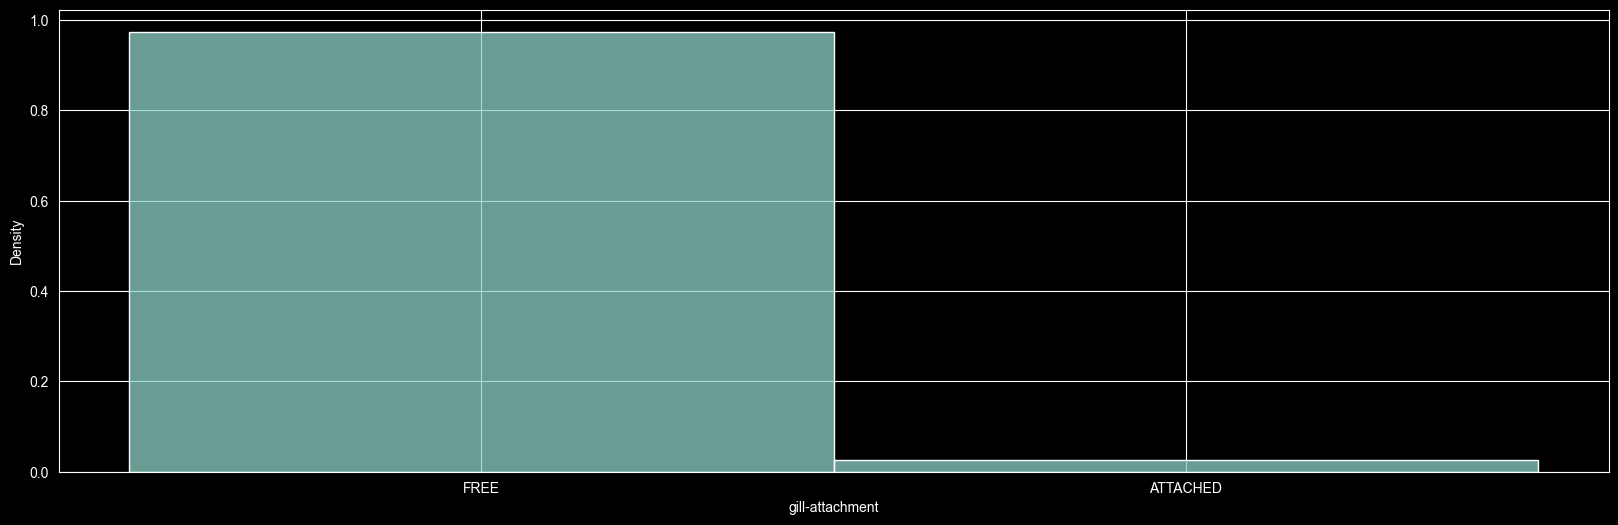

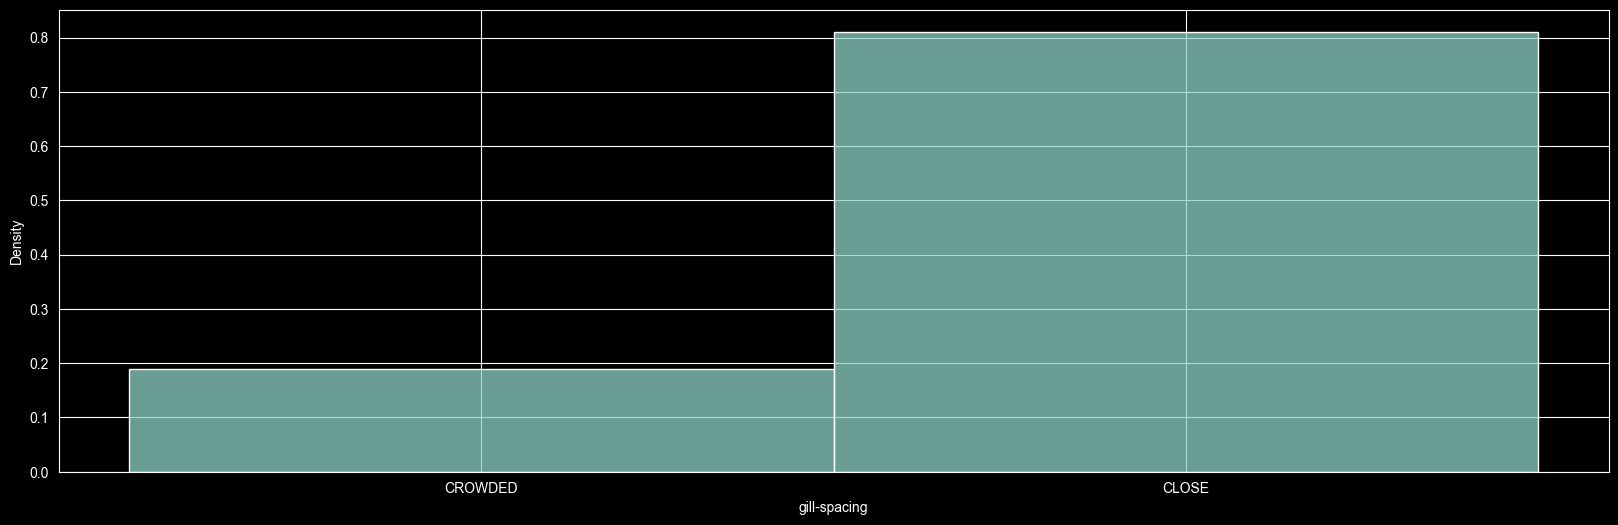

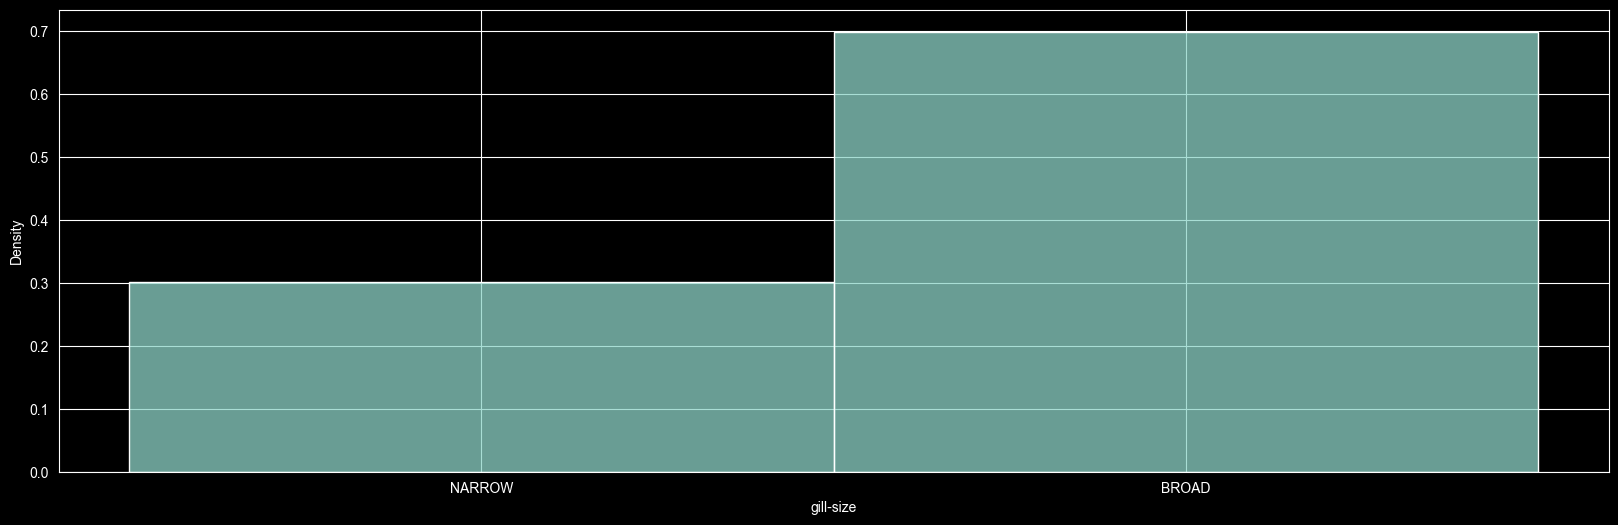

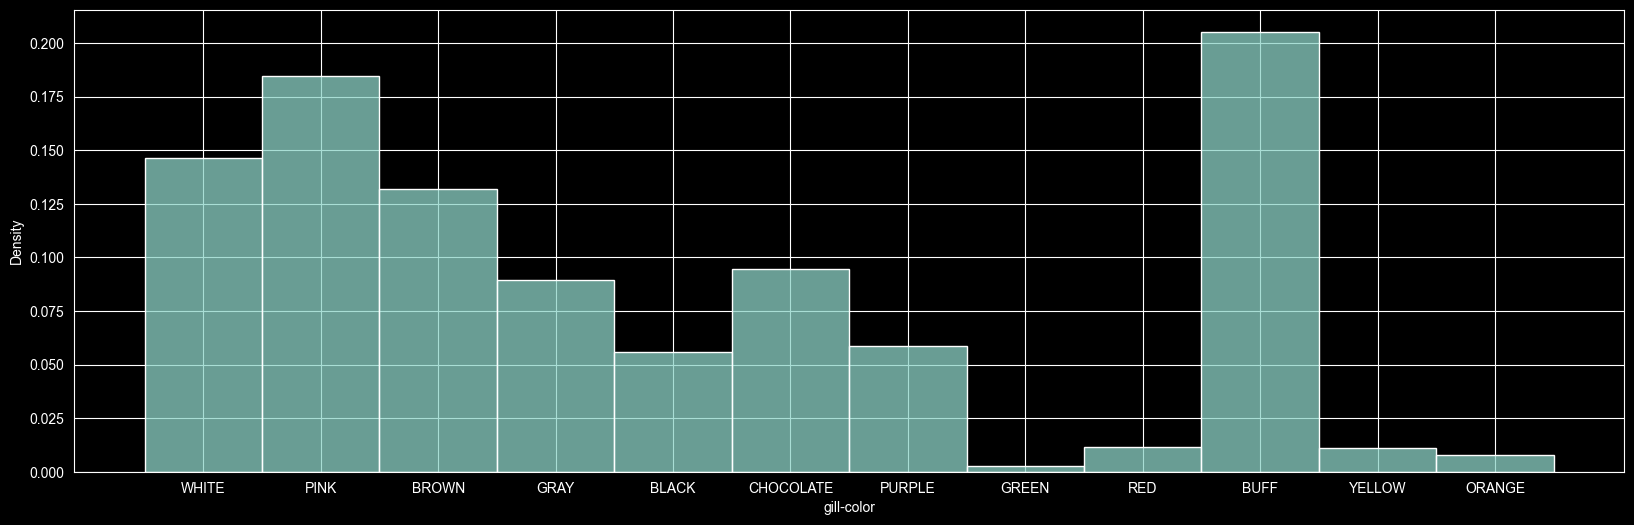

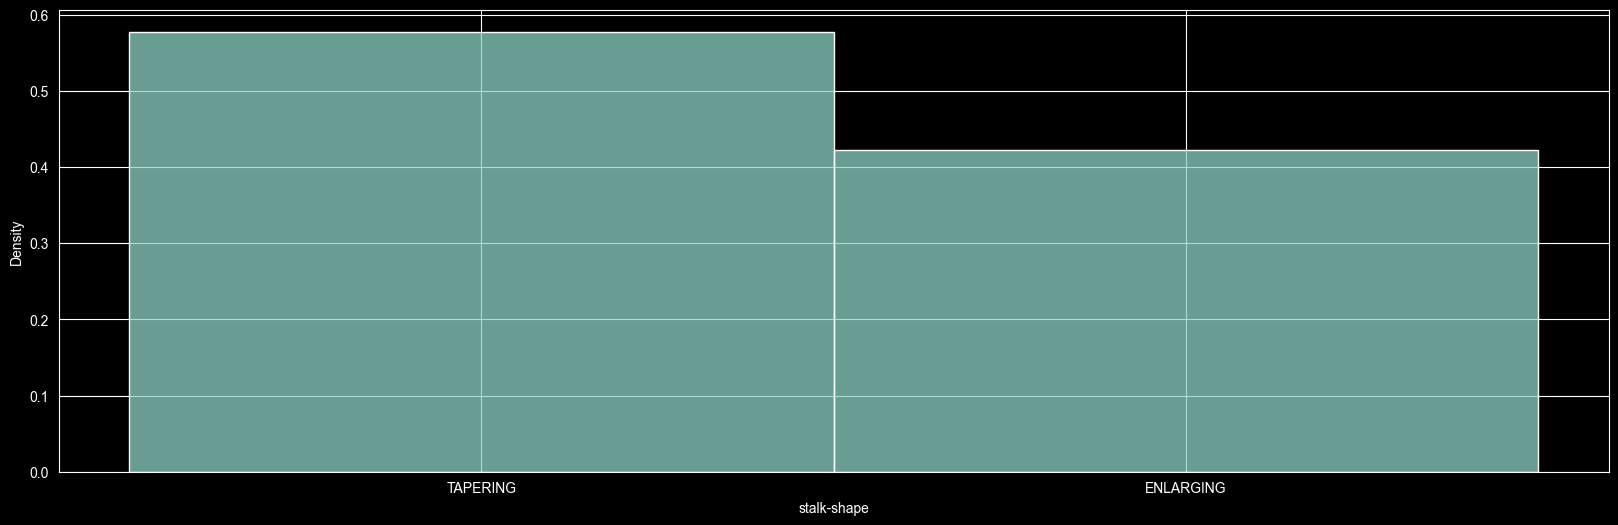

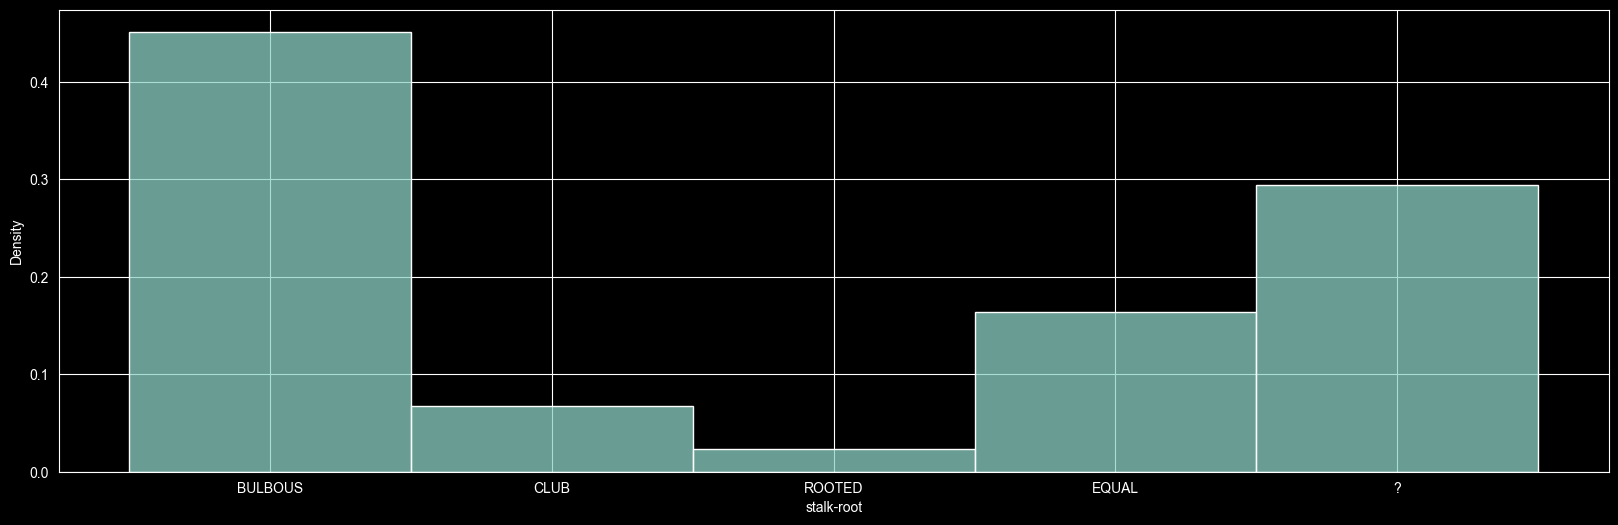

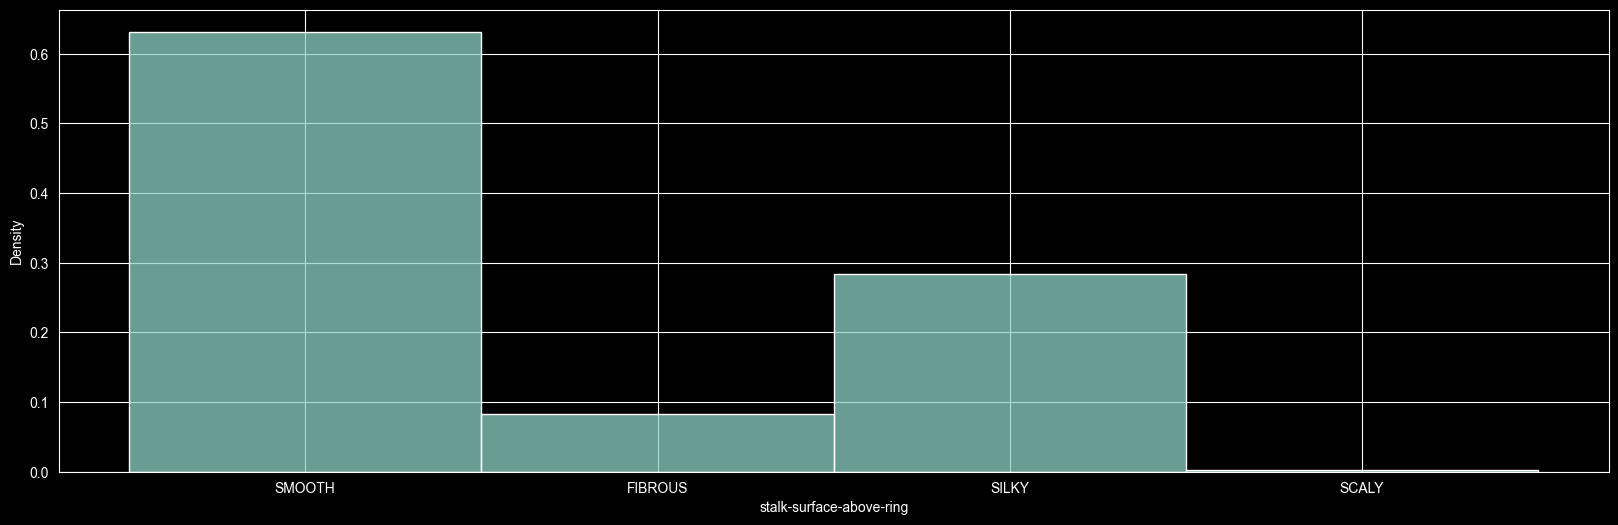

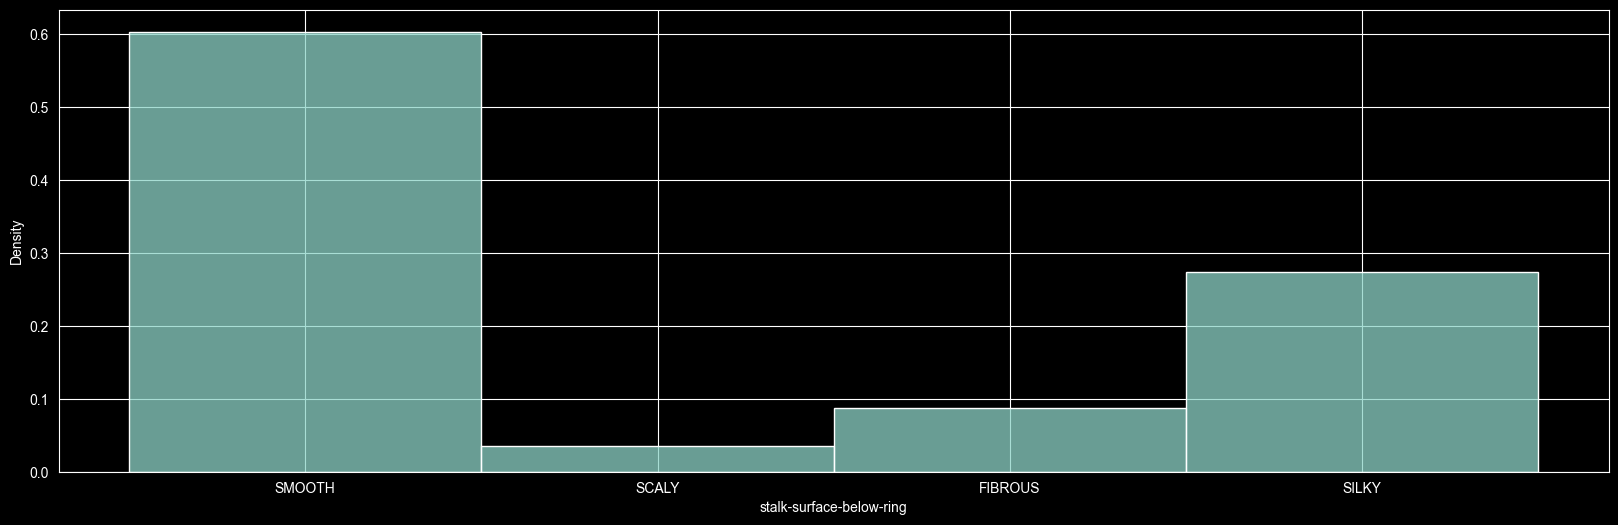

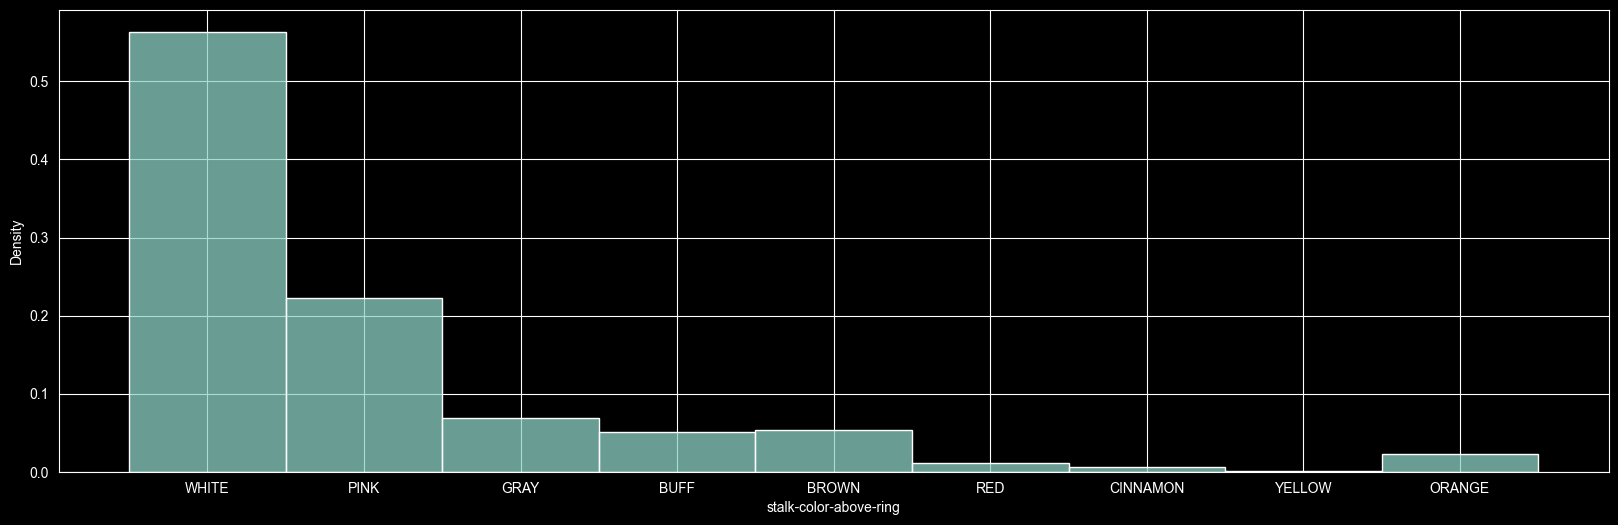

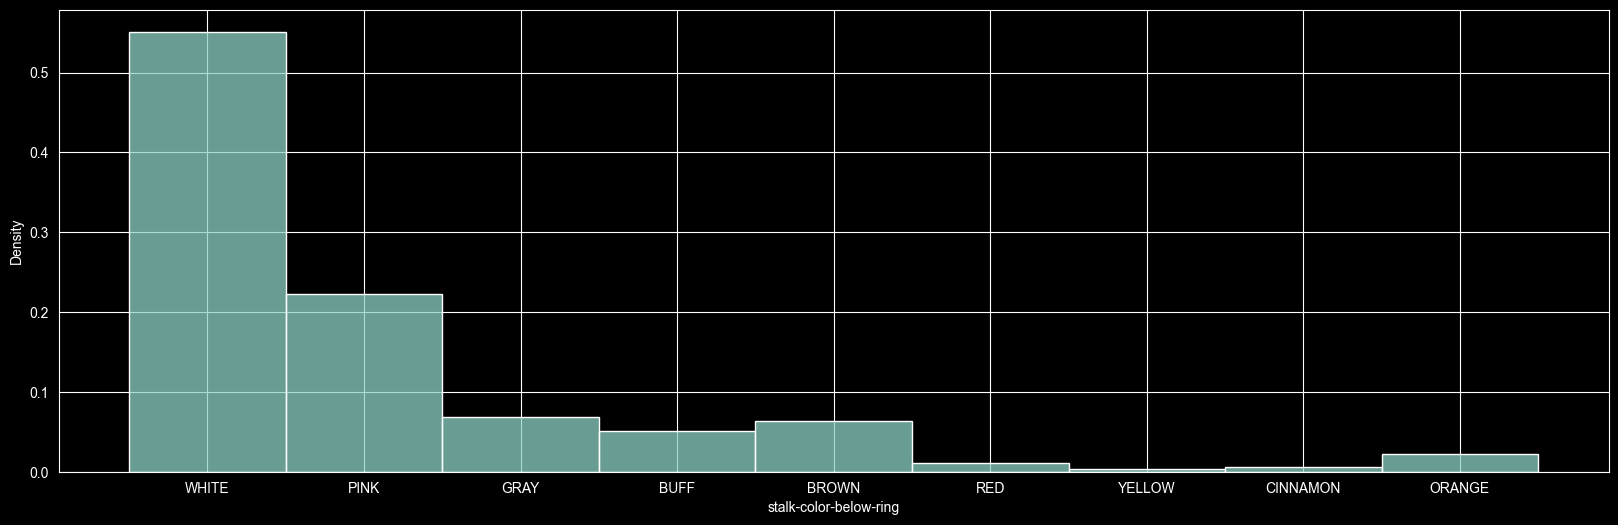

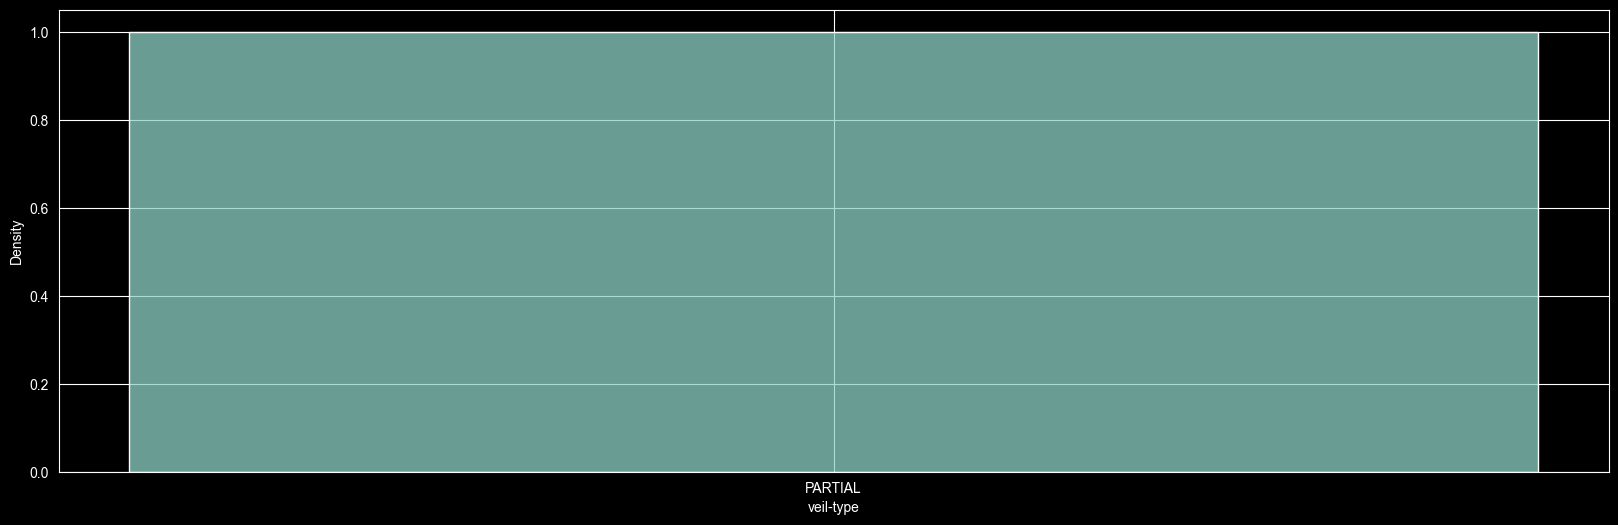

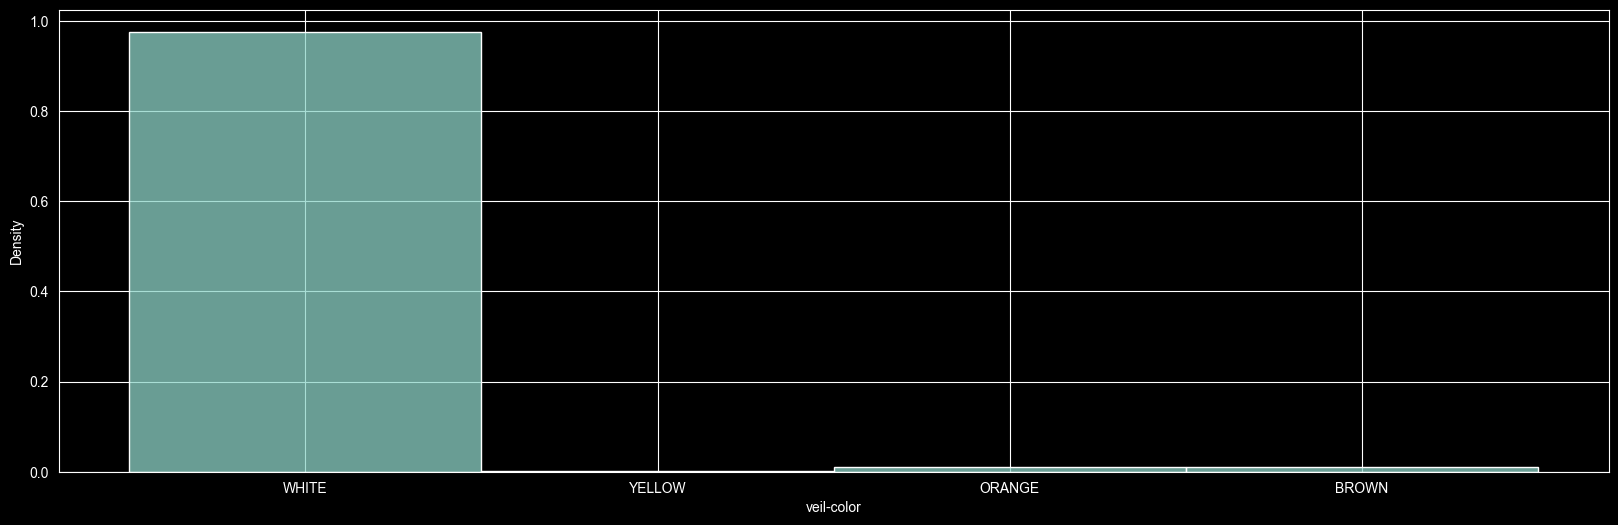

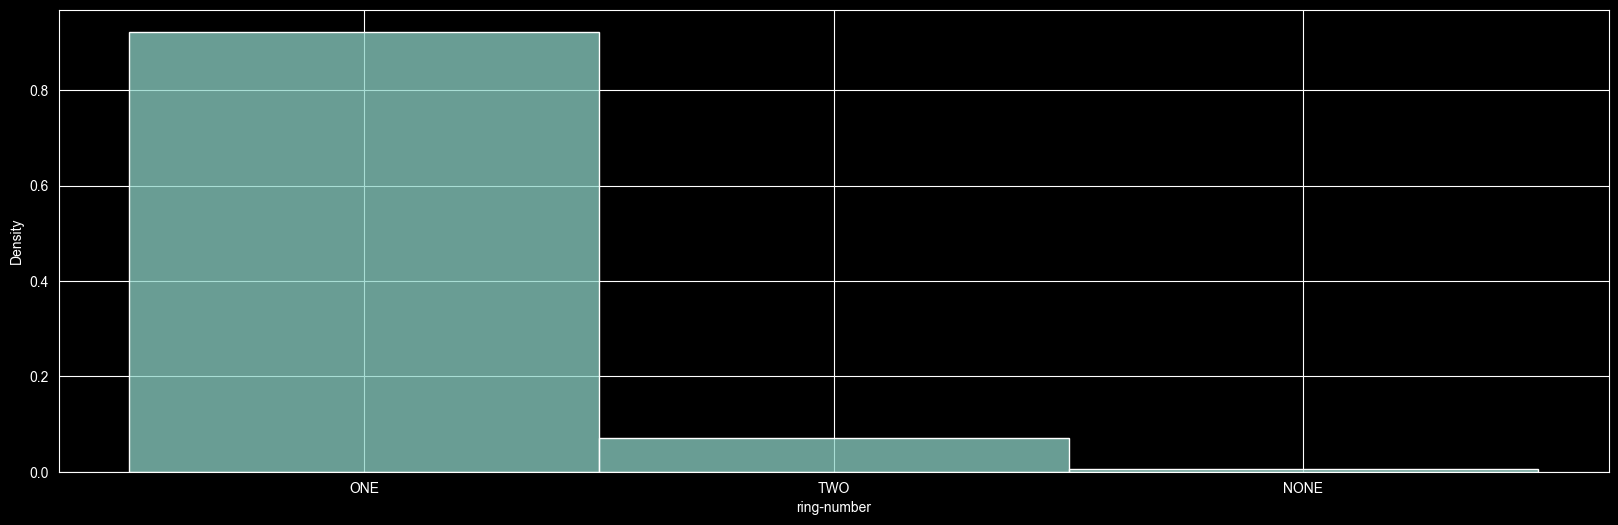

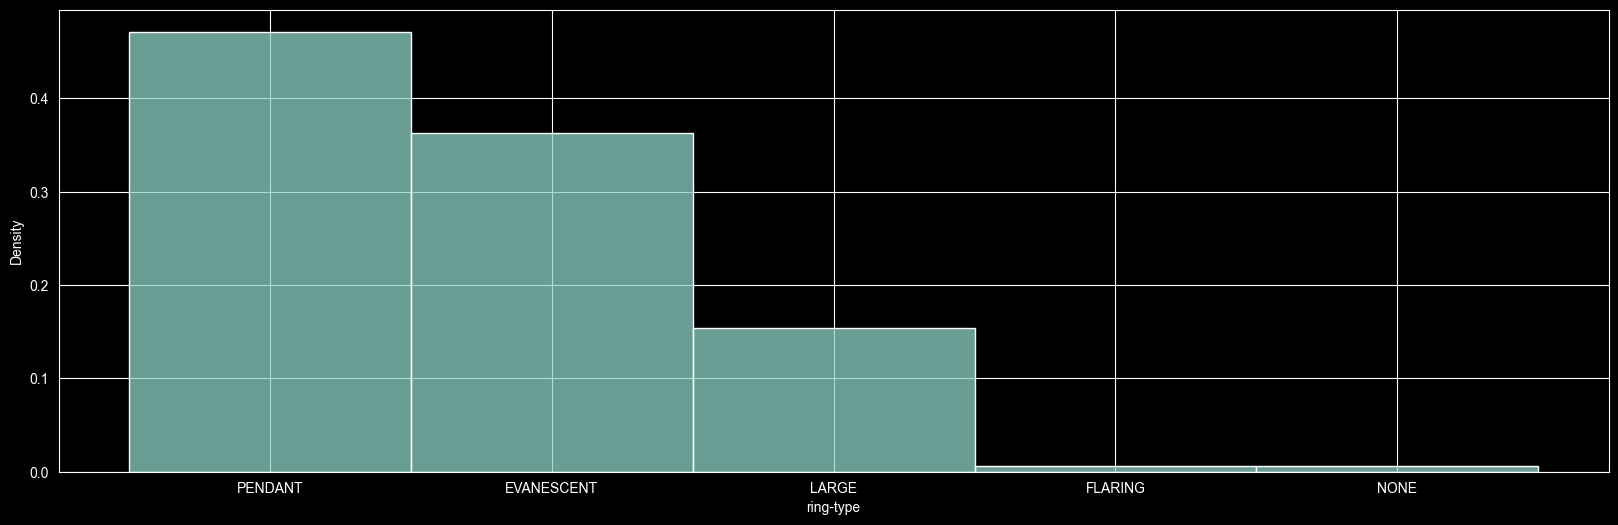

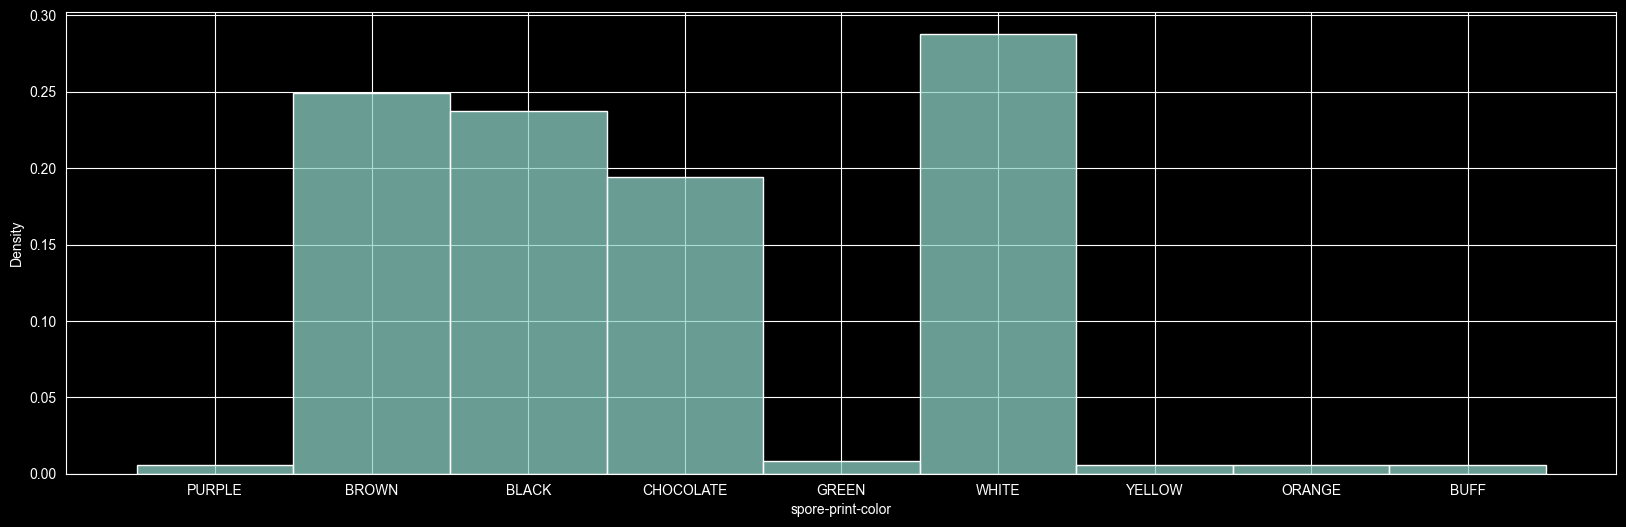

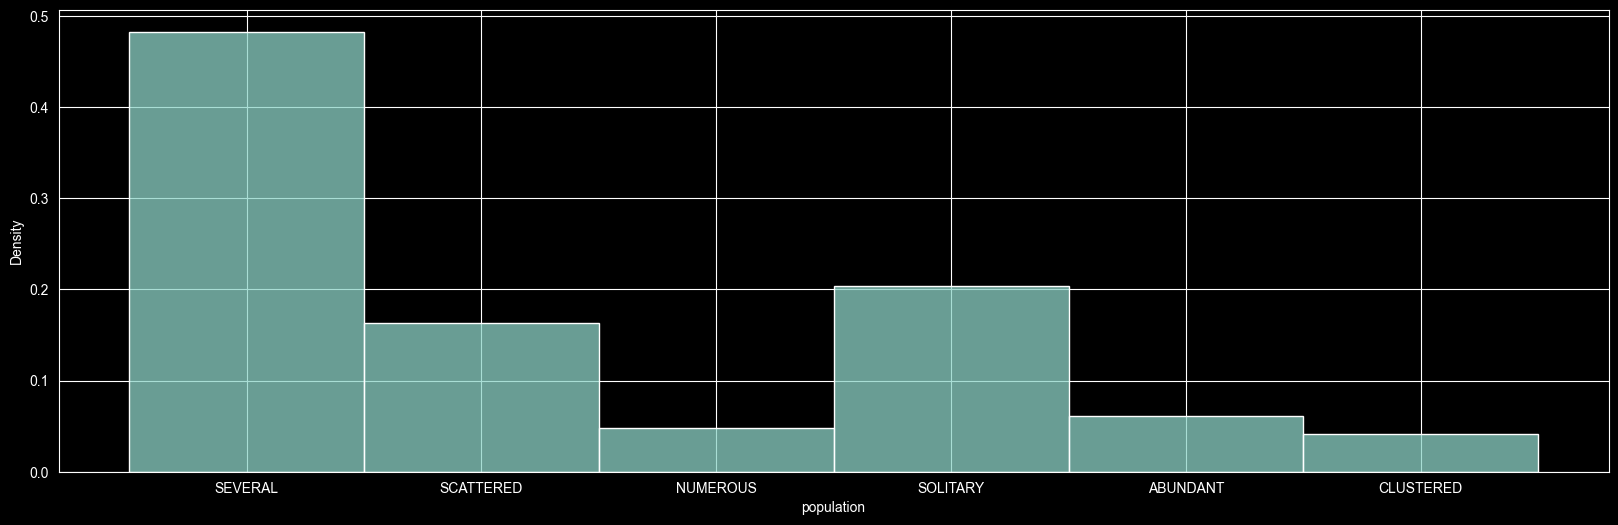

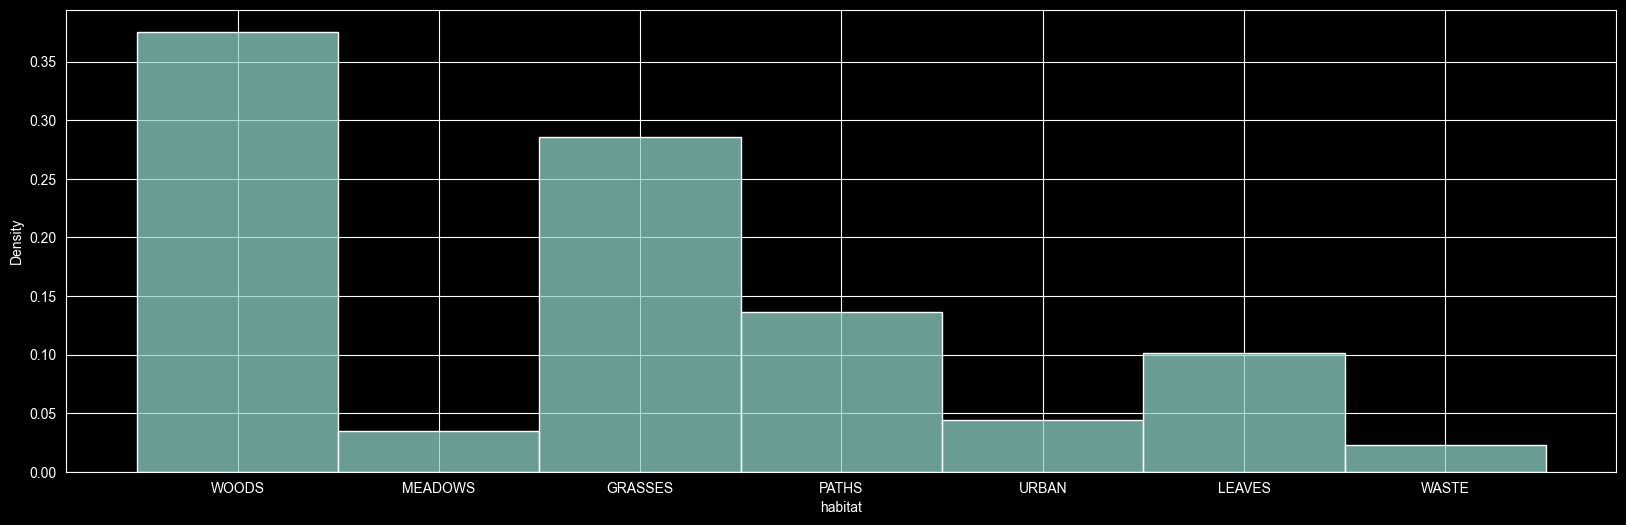

In [6]:
for i in dfm.columns:
    plt.figure(i)
    sns.histplot(dfm[i],stat="density")
    plt.show()

# Важность признаков

In [7]:
le = preprocessing.LabelEncoder()
for column_name in dfm.columns:
    dfm[column_name]=le.fit_transform(dfm[column_name])
Y=dfm.iloc[:, 0:1].values.ravel()
X=dfm.iloc[:, 1:23]

In [8]:
clf = RandomForestClassifier(criterion='entropy', random_state=0)
clf.fit(X, Y)

,n_estimators,100
,criterion,'entropy'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


<Axes: >

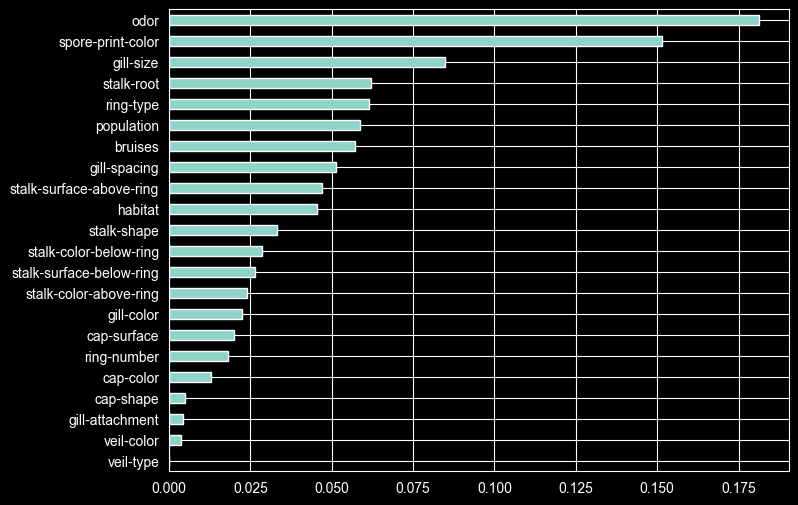

In [9]:
target_col = 'class' if 'class' in dfm.columns else dfm.columns[0]
feat_importances = pd.Series(clf.feature_importances_, index=pd.get_dummies(dfm.drop(columns=[target_col])).columns)
feat_importances.sort_values(ascending=True).plot(kind='barh', figsize=(8, 6))


In [10]:
labels = dfm[target_col]

label_map = {'e': 0, 'p': 1}
if set(labels.unique()).issubset(label_map): y = labels.map(label_map).to_numpy()
else:
    unique_vals = sorted(labels.unique())
    dynamic_map = {val: idx for idx, val in enumerate(unique_vals)}
    y = labels.map(dynamic_map).to_numpy()

X = pd.get_dummies(dfm.drop(columns=[target_col]), dtype=float).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, random_state=42
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (5891, 22), Test: (2525, 22)


In [11]:
model = MLP(in_features=X_train.shape[1], num_classes=2)

history = model.train(
    X_train, y_train,
    X_test, y_test,
    epochs=30,
    batch_size=32
)

Epoch 1/30 | Train Loss: 0.50299, Train Acc: 0.77355 | Test Loss: 0.38731, Test Acc: 0.84515
Epoch 2/30 | Train Loss: 0.36082, Train Acc: 0.86199 | Test Loss: 0.35277, Test Acc: 0.84436
Epoch 3/30 | Train Loss: 0.32622, Train Acc: 0.86963 | Test Loss: 0.29428, Test Acc: 0.87208
Epoch 4/30 | Train Loss: 0.27475, Train Acc: 0.88372 | Test Loss: 0.29001, Test Acc: 0.89703
Epoch 5/30 | Train Loss: 0.22104, Train Acc: 0.90579 | Test Loss: 0.20928, Test Acc: 0.89782
Epoch 6/30 | Train Loss: 0.17537, Train Acc: 0.92786 | Test Loss: 0.15010, Test Acc: 0.94891
Epoch 7/30 | Train Loss: 0.13435, Train Acc: 0.94534 | Test Loss: 0.11063, Test Acc: 0.96594
Epoch 8/30 | Train Loss: 0.10438, Train Acc: 0.96435 | Test Loss: 0.09319, Test Acc: 0.95604
Epoch 9/30 | Train Loss: 0.08075, Train Acc: 0.97318 | Test Loss: 0.06037, Test Acc: 0.98416
Epoch 10/30 | Train Loss: 0.06272, Train Acc: 0.98201 | Test Loss: 0.08898, Test Acc: 0.96594
Epoch 11/30 | Train Loss: 0.04993, Train Acc: 0.98506 | Test Loss: 0.

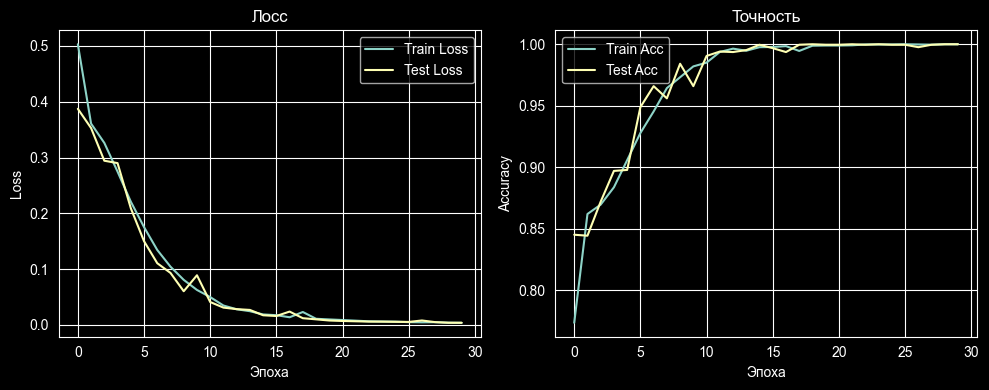

In [12]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["test_loss"], label="Test Loss")
plt.title("Лосс")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["test_acc"], label="Test Acc")
plt.title("Точность")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
test_logits = model.forward(X_test)
test_probs = softmax(test_logits)
y_test_np = device.to_cpu(y_test)
y_pred_test = device.to_cpu(device.xp.argmax(test_probs, axis=1))

cm = confusion_matrix(y_test_np, y_pred_test, labels=list(range(2)))
print("Матрица неточностей:")
print(cm)

accuracy = np.trace(cm) / np.sum(cm)
precision_per_class = np.divide(
    np.diag(cm),
    cm.sum(axis=0),
    out=np.zeros(2, dtype=float),
    where=cm.sum(axis=0) != 0,
)
recall_per_class = np.divide(
    np.diag(cm),
    cm.sum(axis=1),
    out=np.zeros(2, dtype=float),
    where=cm.sum(axis=1) != 0,
)
f1_per_class = np.divide(
    2 * precision_per_class * recall_per_class,
    precision_per_class + recall_per_class,
    out=np.zeros(2, dtype=float),
    where=(precision_per_class + recall_per_class) != 0,
)

print("\nКлассификационный отчет по scikit-learn:")
print(classification_report(y_test_np, y_pred_test, digits=4))

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision_per_class.mean():.4f}")
print(f"Recall (macro): {recall_per_class.mean():.4f}")
print(f"F1 (macro): {f1_per_class.mean():.4f}")

Матрица неточностей:
[[1355    0]
 [   0 1170]]

Классификационный отчет по scikit-learn:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1355
           1     1.0000    1.0000    1.0000      1170

    accuracy                         1.0000      2525
   macro avg     1.0000    1.0000    1.0000      2525
weighted avg     1.0000    1.0000    1.0000      2525

Accuracy: 1.0000
Precision (macro): 1.0000
Recall (macro): 1.0000
F1 (macro): 1.0000


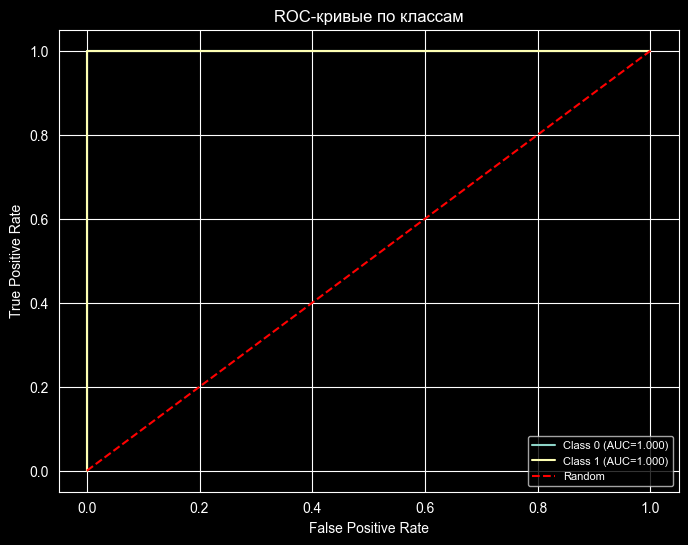

Mean AUC: 1.0000


In [14]:
y_test_binarized = label_binarize(y_test_np, classes=np.arange(10))
probs_cpu = device.to_cpu(test_probs)
auc_scores = []

plt.figure(figsize=(8, 6))
for i in range(2):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], probs_cpu[:, i])
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "r--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривые по классам")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.show()

print(f"Mean AUC: {np.mean(auc_scores):.4f}")

In [15]:
misclassified_idx = np.where(y_pred_test != y_test_np)[0]
print(f"Ошибочно классифицировано: {misclassified_idx.size} образцов из {y_test_np.size}")

Ошибочно классифицировано: 0 образцов из 2525
